In [1362]:
import torch 
import gpytorch
import config_safeopt as cfg
from GPTrainer import GPTrainer
import math
import gp_config as gp_cfg    
from beta import beta_srinivas09 as beta
train_x = cfg.INITIAL_X
train_y = cfg.INITIAL_Y
%load_ext autoreload 
%autoreload 2
# gp_trainer = GPTrainer(gp_cfg, train_x, train_y)

Q_lower = torch.full_like(cfg.DOMAIN.flatten(), -1e9)
Q_upper = torch.full_like(cfg.DOMAIN.flatten(), 1e9)
Q_lower[cfg.INITIAL_SAFE_INDICES] = cfg.SAFETY_THRESHOLD #
    
S_mask = torch.zeros(cfg.N_POINTS, dtype=torch.bool)
S_mask[cfg.INITIAL_SAFE_INDICES] = True
    
# Pre-compute pairwise distances for the discrete domain D
distance_matrix = torch.cdist(cfg.DOMAIN, cfg.DOMAIN) 

gp_trainer = GPTrainer(gp_cfg, train_x, train_y) 
gp_trainer.model.covar_module.base_kernel.lengthscale = 0.1
train_x = [] 
train_y = []  
i = 1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1765]:

# gp_trainer.train_s(train_x, train_y)
print("l_scale --" ,gp_trainer.model.covar_module.base_kernel.lengthscale.item())
print("output scale  -- " ,gp_trainer.model.covar_module.outputscale)

S_prev_indices = torch.where(S_mask)[0]
new_S_mask = S_mask.clone()
 
for s_idx in S_prev_indices:
    lipschitz_safe = Q_lower[s_idx] - cfg.LIPSCHITZ_CONSTANT * distance_matrix[s_idx] >= cfg.SAFETY_THRESHOLD
    new_S_mask = torch.logical_or(new_S_mask, lipschitz_safe)
    safety_val  =  Q_lower[s_idx] - cfg.LIPSCHITZ_CONSTANT * distance_matrix[s_idx]
S_mask = new_S_mask

if not torch.any(S_mask):
    print(f"Iteration {i+1}: Safe set is empty. Stopping.")
    

wt_D = Q_upper - Q_lower
wt_S = torch.full_like(wt_D, -1e9)
wt_S[S_mask] = wt_D[S_mask]

xt = cfg.DOMAIN[torch.argmax(wt_S)]
yt = cfg.ground_truth(xt) + torch.randn(1) * 0.01 # 

if len(train_x) == 0 :
    train_x = xt.unsqueeze(0)
    train_y = yt 
else :
    train_x = torch.cat([train_x, xt.unsqueeze(0)])
    train_y = torch.cat([train_y, yt])

print(f"Final train set size : {len(train_x)} \n Final safe set = {torch.where(S_mask)[0].tolist()}")

gp_trainer.update_training_data(train_x,train_y)
gp_trainer.model.covar_module.base_kernel.lengthscale = 0.1
# gp_trainer.train()
mean, std_dev = gp_trainer.get_posterier(cfg.DOMAIN)

beta_t_sqr = math.sqrt(beta(i,cfg.N_POINTS,math.sqrt(gp_trainer.model.likelihood.noise.item()),gp_trainer.model.covar_module.outputscale))

Q_lower = mean - beta_t_sqr * std_dev
Q_upper = mean + beta_t_sqr * std_dev
# Q_lower = mean - cfg.BETA * std_dev  # const beta 
# Q_upper = mean + cfg.BETA * std_dev
print(beta_t_sqr)
i+=1

l_scale -- 0.10000000149011612
output scale  --  tensor(0.6931, grad_fn=<SoftplusBackward0>)
Final train set size : 400 
 Final safe set = [1, 2]
28455.655895498792


In [1364]:
for i in range(len(S_mask)): 
    if cfg.ground_truth(cfg.DOMAIN[i]) < cfg.SAFETY_THRESHOLD and S_mask[i]==True: 
        print(f"below threshold{cfg.DOMAIN[i]}")

In [1365]:
# S_mask[80] = 1
print(distance_matrix)

tensor([[0.0000, 0.0050, 0.0101,  ..., 0.9899, 0.9950, 1.0000],
        [0.0050, 0.0000, 0.0050,  ..., 0.9849, 0.9899, 0.9950],
        [0.0101, 0.0050, 0.0000,  ..., 0.9799, 0.9849, 0.9899],
        ...,
        [0.9899, 0.9849, 0.9799,  ..., 0.0000, 0.0050, 0.0101],
        [0.9950, 0.9899, 0.9849,  ..., 0.0050, 0.0000, 0.0050],
        [1.0000, 0.9950, 0.9899,  ..., 0.0101, 0.0050, 0.0000]])


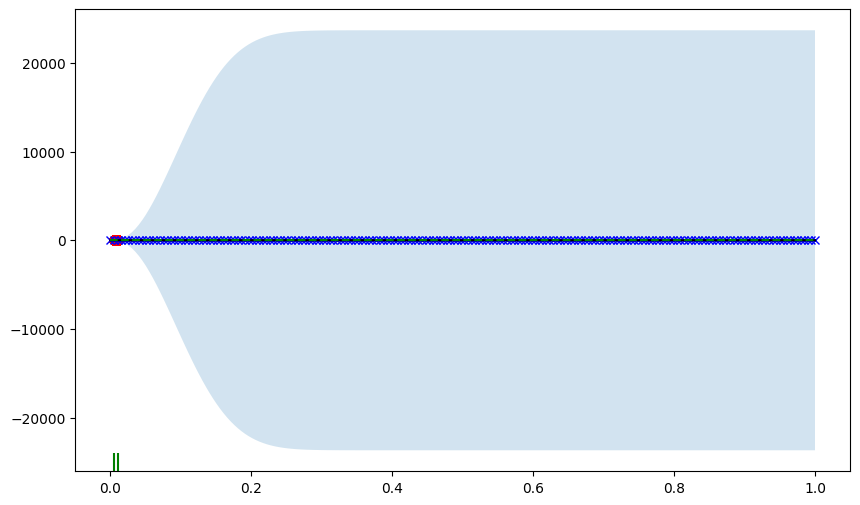

In [1766]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))
ax = plt.gca()
trans = ax.get_xaxis_transform()
safe_x = cfg.DOMAIN[S_mask]
ax.scatter(
        safe_x,
        np.full_like(safe_x, 0.02),  # Y position (2% from bottom)
        marker='|',
        color='green',
        s=150,                     # Size of the bars
        label='Safe Points',
        transform=trans            # Apply the transform
    )
plt.plot(train_x.numpy(), train_y.numpy(), 'ro', label='Training Data')
plt.plot(cfg.DOMAIN.numpy(), cfg.ground_truth(cfg.DOMAIN).numpy(), 'bx--', label='Ground Truth')
plt.plot(cfg.DOMAIN.numpy(), mean.numpy(), 'k-', label='GP Mean')
plt.plot(cfg.DOMAIN.numpy(), cfg.SAFETY_THRESHOLD * torch.ones_like(cfg.DOMAIN).numpy(), 'g--', label='Safety Threshold')
plt.fill_between(cfg.DOMAIN.numpy().flatten(), Q_lower.numpy(), Q_upper.numpy(), alpha=0.2, label='Q Bounds')